<center><h1>Facies classification using Machine Learning</h1><center>

<center>
<h2>ICPE 689– Data Science for Intelligent Oil Filed Operations – Spring 2021</h2>    
<h3>Texas A&amp;M University<br>
Harold Vance Department of Petroleum Engineering<br><br>
Dr. Eduardo Gildin<br>
Marcelo Dall'Aqua<br><br>
Spring 2021<br>    
</h3>
</center>


##### Based on the Hall, Brandon - Facies classification using machine learning (2016). Geophysical Tutorial


This notebook demonstrates how to train a machine learning algorithm to **predict facies from well log data**. The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from **nine wells** that have been **labeled** with a facies type based on oberservation of core. We will use this log data to train, step-by-step, a **support vector machine** to classify facies types. Then we will compare with other algortihms: **Logistic Regression**, **K-Nearest Neiighbor** and **Random Forest**.

First we will [explore the dataset](#Exploring-the-dataset).  We will load the training data from 9 wells, and take a look at what we have to work with.  We will plot the data from a couple wells, and create cross plots to look at the variation within the data.  

Next we will [condition the data set](#Conditioning-the-data-set).  We will remove the entries that have incomplete data.  The data will be scaled to have zero mean and unit variance.  We will also split the data into training and test sets.

We will then be ready to [build the SVM classifier](#Building-the-SVM-classifier).  We will demonstrate how to use the cross validation set to do [model parameter selection](#Model-parameter-selection).

Finally, once we have a built and tuned the classifier, we can [apply the trained model](#Applying-the-classification-model-to-new-data) to classify facies in wells which do not already have labels.  We will apply the classifier to two wells, but in principle you could apply the classifier to any number of wells that had the same log data.

## Exploring the dataset

First, we will examine the data set we will use to train the classifier.  The training data is contained in the file `facies_training_data.csv`.  The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals.  In machine learning terminology, each log measurement is a **feature vector** that maps a set of **'features'** (the log measurements) to a class (the facies type).  We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)

In [2]:
import pandas as pd


filename = 'facies_training_data.csv'
training_data = pd.read_csv(filename)
training_data


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10), [neutron-density porosity difference and average neutron-densityporosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND), [photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone - SS
2. Nonmarine coarse siltstone - CSiS
3. Nonmarine fine siltstone - FSiS
4. Marine siltstone and shale - SiSh
5. Mudstone (limestone) - MS
6. Wackestone (limestone) - WS
7. Dolomite - D
8. Packstone-grainstone (limestone) - PS
9. Phylloid-algal bafflestone (limestone) - BS

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [3]:
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [4]:
##### Insert your code here #############
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data

training_data['Well Name'].unique()
#########################################

['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', ..., 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']

These are the names of the 10 training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone. 

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels, and add those to the `facies_vectors` dataframe.

In [5]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']


#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = dict(zip(facies_labels, facies_colors))

## Include a column with the Facies labes                                        
facies_labels_dic = dict(enumerate(facies_labels,start=1))

training_data['FaciesLabels'] = training_data.Facies.map(facies_labels_dic)
training_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS


Let's take a quick view of the statistical distribution of the input variables.  

In [6]:
##### Insert your code here #############
training_data.describe()
#########################################

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


Looking at the `count` values, most values have 4149 valid values except for `PE`, which has 3232.  In this tutorial we will drop the feature vectors that don't have a valid `PE` entry.

In [7]:
##### Insert your code here #############
pe_mask = training_data['PE'].notnull().values
training_data = training_data[pe_mask]
training_data.describe()
#########################################

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.  The plot function is a modified versionn of [Alessandro Amato del Monte's tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

In [8]:
def make_facies_log_plot(logs, facies_colors):
    n_facies  = len(facies_colors)
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')

    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0.5,vmax=n_facies+.5)
    cbar=plt.colorbar(im,ticks=np.arange(1,n_facies+1))
    cbar.set_ticklabels(facies_labels)
  
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);
    ax[5].set_yticklabels([]); ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells.  The function was written to take a list of colors and facies labels as parameters.  

We then show log plots for well `SHRIMPLIN`

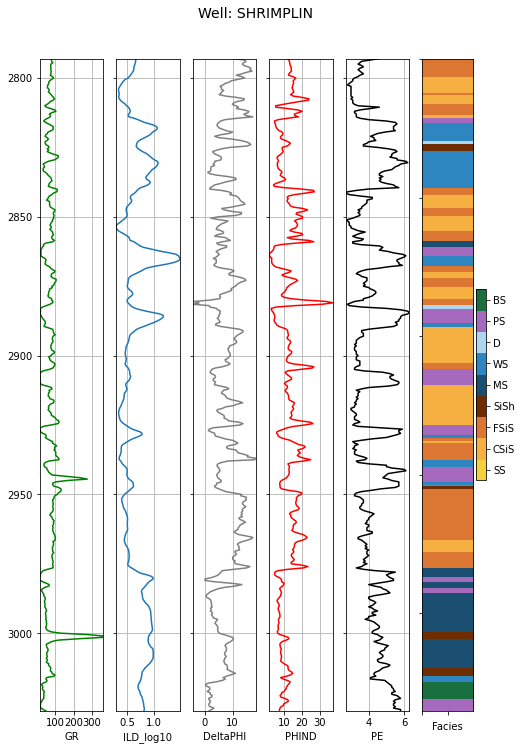

In [9]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

and for well `SHANKLE`

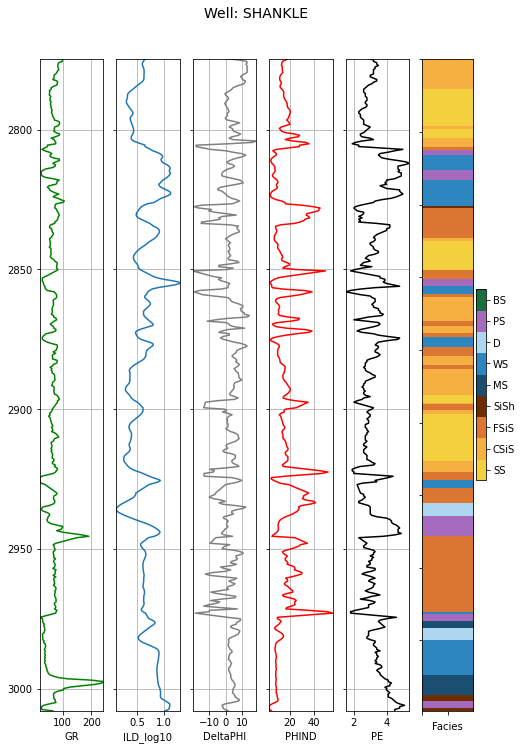

In [10]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHANKLE'],
    facies_colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histogram of the number of training examples for each facies class.

In [11]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()

#use facies labels to index each count
facies_counts.index = facies_labels
facies_counts

SS      259
CSiS    738
FSiS    615
SiSh    184
MS      217
WS      462
D        98
PS      498
BS      161
Name: Facies, dtype: int64

<AxesSubplot:ylabel='Facies'>

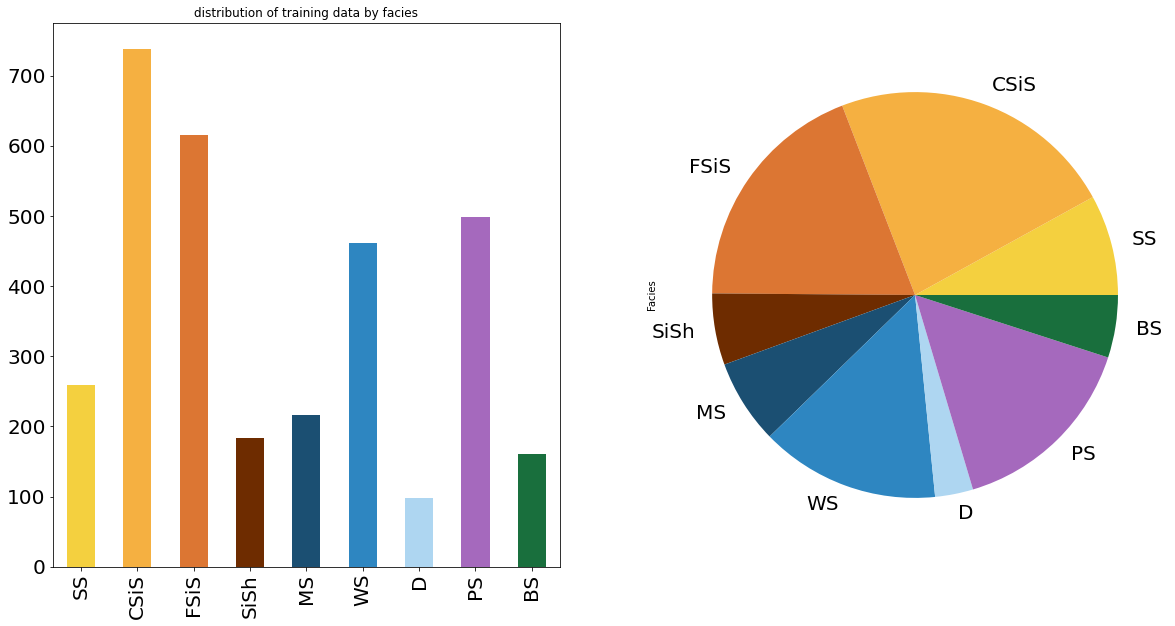

In [12]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))

# Histogram plot
##### Insert your code here #############
facies_counts.plot(ax=axes[0], kind='bar', color=facies_colors, fontsize=20, title='distribution of training data by facies')
#########################################

# Pie plot
##### Insert your code here #############
facies_counts.plot.pie(ax=axes[1], colors=facies_colors, fontsize=20)
#########################################

Text(0, 0.5, 'Numbers')

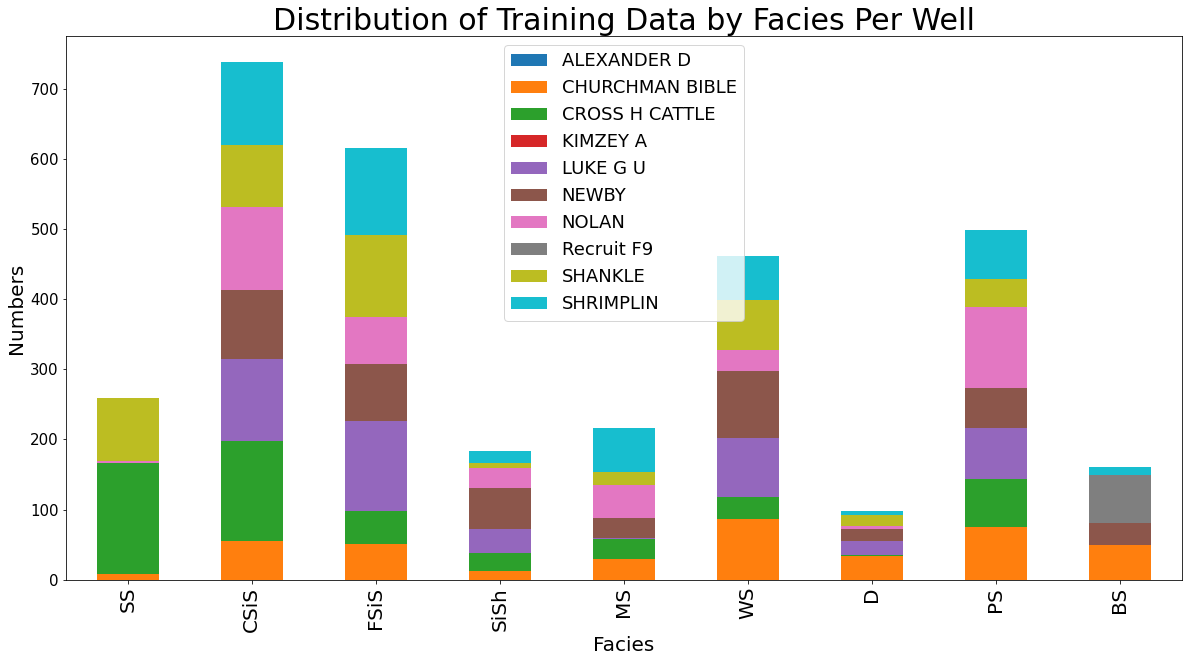

In [13]:
# Plot the Distribution of Training Data by Facies Per Well
##### Insert your code here #############
facies_counts = training_data.groupby(['Facies', 'Well Name'])['Facies'].count().unstack()
facies_counts.plot(kind='bar', stacked=True, figsize=(20,10), fontsize=20)

#########################################


# Set Axis Properties
plt.xticks(np.arange(9),labels=facies_labels,fontsize = 20)
plt.yticks(fontsize = 15)
plt.title('Distribution of Training Data by Facies Per Well', fontsize = 30)
plt.legend(loc='best', prop={'size': 18})
plt.xlabel('Facies', fontsize = 20)
plt.ylabel('Numbers', fontsize = 20)

This shows the distribution of examples by facies for the 3232 training examples in the training set.  Dolomite (facies 7) has the fewest with 141 examples.  There are also only 185 bafflestone examples.  Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset.  We can employ the very useful [Seaborn library](https://stanford.edu/~mwaskom/software/seaborn/) to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies.  The same colormap is used to represent the 9 facies.  

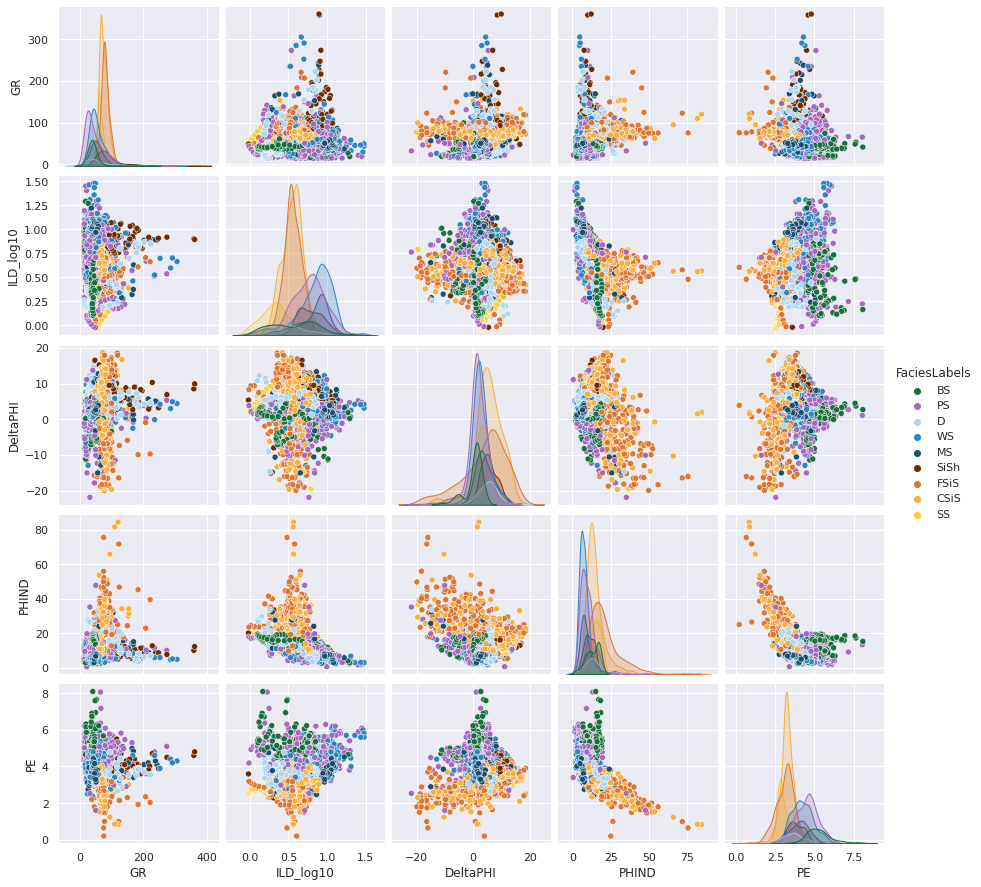

In [14]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=reversed(facies_labels))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)


Unfortunetaly, it is not clear from these crossplot what relationships exist between the measurements facies. This is where machine learning will prove useful.

## Machine Learning

### Conditioning the data set

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [15]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [16]:
feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,78.260,0.661,14.200,12.565,4.100,1,0.979
2,79.050,0.658,14.800,13.050,3.600,1,0.957
3,86.100,0.655,13.900,13.115,3.500,1,0.936
4,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...
4144,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,51.469,0.965,3.083,7.708,3.152,2,0.661


Scikit includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data (giving each variable zero mean and unit variance, also called *whitening*).  Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance).  The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier.  The `StandardScalar` class can be fit to the training set, and later used to standardize any training data.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [18]:
## Original 
feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,78.260,0.661,14.200,12.565,4.100,1,0.979
2,79.050,0.658,14.800,13.050,3.600,1,0.957
3,86.100,0.655,13.900,13.115,3.500,1,0.936
4,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...
4144,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,51.469,0.965,3.083,7.708,3.152,2,0.661


In [19]:
## Scaled
scaled_features_pd = pd.DataFrame( data = scaled_features, columns  = feature_vectors.columns)
scaled_features_pd

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,0.366749,0.088008,1.212737,-0.203723,0.976532,-0.996911,1.672943
1,0.393005,0.075601,2.035209,-0.119283,0.418505,-0.996911,1.599708
2,0.418613,0.063194,2.149973,-0.056278,-0.139522,-0.996911,1.522985
3,0.647138,0.050788,1.977828,-0.047834,-0.251128,-0.996911,1.449750
4,0.273719,0.017704,1.901319,-0.023801,-0.362733,-0.996911,1.376515
...,...,...,...,...,...,...,...
3227,-0.629392,1.258362,-0.331216,-0.809221,-0.120549,1.003099,0.574416
3228,-0.699278,1.283175,-0.252220,-0.710621,-0.425232,1.003099,0.546517
3229,-0.532147,1.328666,-0.121390,-0.710621,-0.597105,1.003099,0.518618
3230,-0.475421,1.332801,-0.091169,-0.750243,-0.639515,1.003099,0.490719


Scikit also includes a handy function to randomly split the training data into training and test sets.  The test set contains a small subset of feature vectors that are not used to train the network.  Because we know the true facies labels for these examples, we can compare the results of the classifier to the actual facies and determine the accuracy of the model.  Let's use 20% of the data for the test set.

In [20]:
from sklearn.model_selection import train_test_split

##### Insert your code here #############
X_train, X_cv, y_train, y_cv = train_test_split(scaled_features,correct_facies_labels, test_size=0.2, random_state=42)


#########################################


In [21]:
scaled_features.shape

(3232, 7)

In [22]:
X_train.shape

(2585, 7)

In [23]:
X_cv.shape

(647, 7)

### Training the SVM classifier

Now we use the cleaned and conditioned training set to create a facies classifier.  As mentioned above, we will use a type of machine learning model known as a [support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine).  The SVM is a map of the feature vectors as points in a multi dimensional space, mapped so that examples from different facies are divided by a clear gap that is as wide as possible.  

The SVM implementation in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) takes a number of important parameters.  First we create a classifier using the default settings.  

In [24]:
from sklearn import svm

svmclf = svm.SVC()

Now we can train the classifier using the training set we created above.

In [25]:
svmclf.fit(X_train,y_train)

SVC()

Now that the model has been trained on our data, we can use it to predict the facies of the feature vectors in the test set.  Because we know the true facies labels of the vectors in the test set, we can use the results to evaluate the accuracy of the classifier.

In [26]:
y_pred_SVM = svmclf.predict(X_cv)

We need some metrics to evaluate how good our classifier is doing.  A [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) is a table that can be used to describe the performance of a classification model.  [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) allows us to easily create a confusion matrix by supplying the actual and predicted facies labels.

The confusion matrix is simply a 2D array.  The entries of confusion matrix `C[i][j]` are equal to the number of observations predicted to have facies `j`, but are known to have facies `i`.  


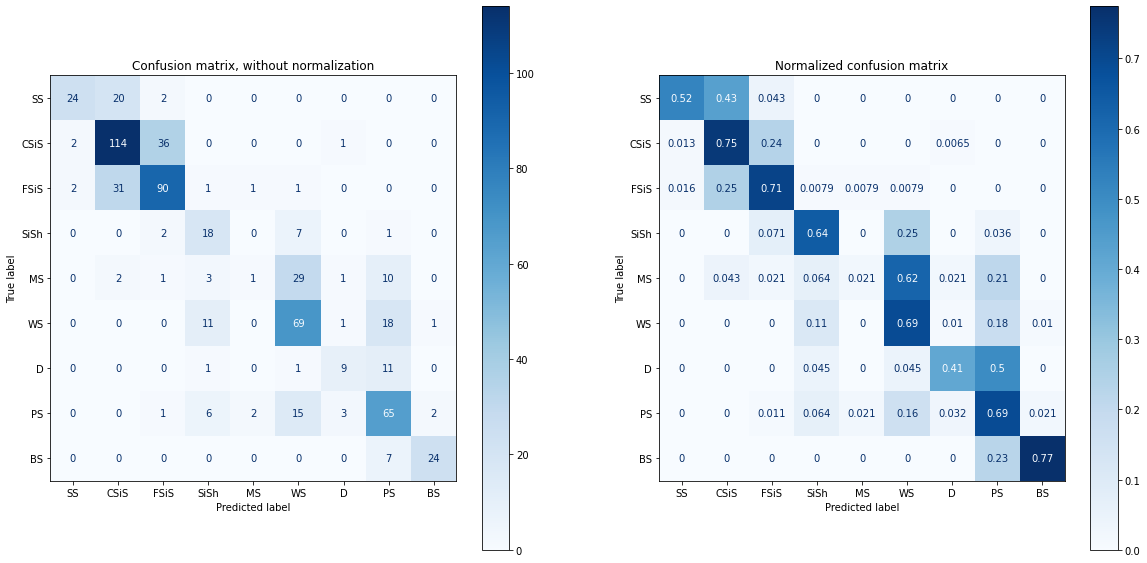

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20,10))

# for i, (a, b) in enumerate(zip(alist, blist)):
for i, (title, normalize) in enumerate(titles_options):
    plot_confusion_matrix(svmclf, X_cv, y_cv, ax=ax[i],
                                 display_labels=facies_labels,
                                 normalize=normalize,
                                 cmap='Blues')
    ax[i].set_title(title)

The rows of the confusion matrix correspond to the actual facies labels.  The columns correspond to the labels assigned by the classifier.  For example, consider the first row. For the feature vectors in the test set that actually have label `SS`, 23 were correctly indentified as `SS`, 21 were classified as `CSiS` and 2 were classified as `FSiS`.

The entries along the diagonal are the facies that have been correctly classified.  Below we define two functions that will give an overall value for how the algorithm is performing.  The accuracy is defined as the number of correct classifications divided by the total number of classifications.

In [28]:
from sklearn.metrics import classification_report
target_names = ['SS', 'CSiS', 'FSiS', 'SiSh','MS', 'WS', 'D','PS', 'BS']

print(classification_report(y_cv, y_pred_SVM, target_names=target_names))

              precision    recall  f1-score   support

          SS       0.86      0.52      0.65        46
        CSiS       0.68      0.75      0.71       153
        FSiS       0.68      0.71      0.70       126
        SiSh       0.45      0.64      0.53        28
          MS       0.25      0.02      0.04        47
          WS       0.57      0.69      0.62       100
           D       0.60      0.41      0.49        22
          PS       0.58      0.69      0.63        94
          BS       0.89      0.77      0.83        31

    accuracy                           0.64       647
   macro avg       0.62      0.58      0.58       647
weighted avg       0.63      0.64      0.62       647



In [29]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i,i]
    acc = total_correct/sum(sum(conf))
    return acc

As noted above, the boundaries between the facies classes are not all sharp, and some of them blend into one another.  The error within these 'adjacent facies' can also be calculated.  We define an array to represent the facies adjacent to each other.  For facies label `i`, `adjacent_facies[i]` is an array of the adjacent facies labels.

In [30]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i,i]
        for j in adjacent_facies[i]:
            total_correct += conf[i,j]
    return total_correct / sum(sum(conf))

In [31]:
conf = confusion_matrix(y_cv, y_pred_SVM)
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.639876
Adjacent facies classification accuracy = 0.916538


### Model parameter selection - Validation

The classifier so far has been built with the default parameters.  However, we may be able to get improved classification results with optimal parameter choices.

We will consider two parameters.  The parameter `C` is a regularization factor, and tells the classifier how much we want to avoid misclassifying training examples.  A large value of C will try to correctly classify more examples from the training set, but if `C` is too large  it may 'overfit' the data and fail to generalize when classifying new data. If `C` is too small then the model will not be good at fitting outliers and will have a large error on the training set.

The SVM learning algorithm uses a kernel function to compute the distance between feature vectors.  Many kernel functions exist, but in this case we are using the radial basis function `rbf` kernel (the default).  The `gamma` parameter describes the size of the radial basis functions, which is how far away two vectors in the feature space need to be to be considered close.

We will train a series of classifiers with different values for `C` and `gamma`.  Two nested loops are used to train a classifier for every possible combination of values in the ranges specified.  The classification accuracy is recorded for each combination of parameter values.  The results are shown in a series of plots, so the parameter values that give the best classification accuracy on the test set can be selected.

This process is also known as 'cross validation'.  Often a separate 'cross validation' dataset will be created in addition to the training and test sets to do model selection.  For this tutorial we will just use the test set to choose model parameters.

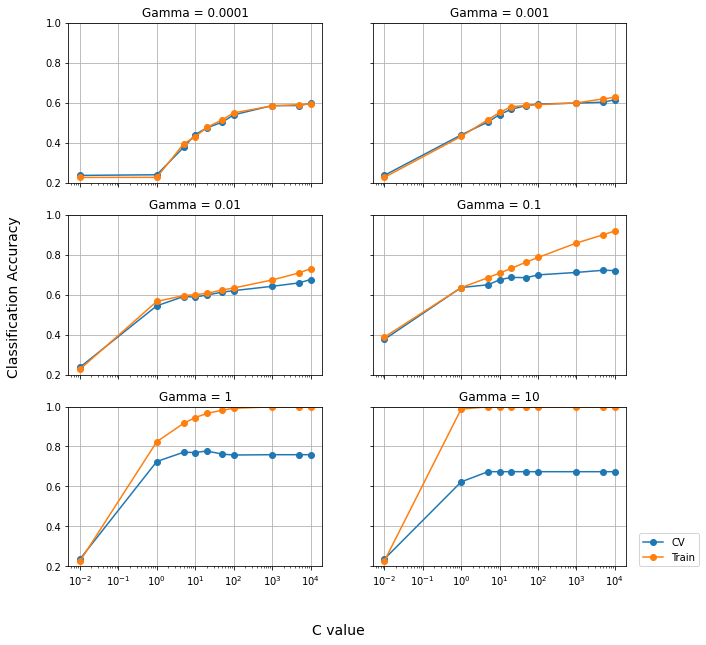

In [32]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = np.int_(plot_number / 2)
        column = plot_number % 2
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C = c_value, gamma = gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_cv, clf.predict(X_cv))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)
        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV',linestyle=None, marker='o')
        ax.semilogx(C_range, train_errors, label='Train',linestyle=None, marker='o')
        plot_number += 1
        ax.set_ylim([0.2,1])
        ax.grid()
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

The best accuracy on the cross validation error curve was achieved for `gamma = 1`, and `C = 10`.  We can now create and train an optimized classifier based on these parameters:

### Cross Validation with Scikit-Learn

Scikit-Learn makes our lifes  very easy, since it has already a function that implements cross-validation. Let's take a look

First, we have to redefine the training set. Please pay attention that we do not need anymore to define a validation set explicitly.

In [33]:
X_train = scaled_features.copy()
y_train = correct_facies_labels.copy()

Instantiate a model for 3-fold cross validation on training data that shuffles the selection of samples from the training dataset into the folds for cross validation.

In [34]:
# instantiate the Kfold CrossValidation
from sklearn.model_selection import KFold

cv_strategy = KFold(n_splits=3, shuffle = True, random_state=125) # creates an instance

Using the cross-validation instantiated above, perform hyperparameter optimization to find the best/optimal values of hyperparameters -- alpha and l1_ratio.
* GridSearchCV will look through a grid and perform Cross Validation for each item in the grid (combinitation of hyperparameters C and gamma)
* We can choose as many values we want for C and gamma
* In the example below it will develop C x gamma x Fold models (10 x 6 x 3 = 180 fits)

In [35]:
# perform hyperparameter optimization for the ELasticNet Model
from sklearn.model_selection import GridSearchCV 

# dictionary with keys
param_grid_strat ={'C': [.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000],
                  'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]} 
# what parameters to search depends on the expert knowledge

grid = GridSearchCV(svmclf, param_grid=param_grid_strat, cv=cv_strategy, verbose=3)  # estimator

grid.fit(X_train, y_train) 

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END ...........................C=0.01, gamma=0.0001; total time=   0.5s
[CV 2/3] END ...........................C=0.01, gamma=0.0001; total time=   0.5s
[CV 3/3] END ...........................C=0.01, gamma=0.0001; total time=   0.5s
[CV 1/3] END ............................C=0.01, gamma=0.001; total time=   0.5s
[CV 2/3] END ............................C=0.01, gamma=0.001; total time=   0.5s
[CV 3/3] END ............................C=0.01, gamma=0.001; total time=   0.5s
[CV 1/3] END .............................C=0.01, gamma=0.01; total time=   0.5s
[CV 2/3] END .............................C=0.01, gamma=0.01; total time=   0.5s
[CV 3/3] END .............................C=0.01, gamma=0.01; total time=   0.5s
[CV 1/3] END ..............................C=0.01, gamma=0.1; total time=   0.5s
[CV 2/3] END ..............................C=0.01, gamma=0.1; total time=   0.5s
[CV 3/3] END ..............................C=0.

[CV 3/3] END ................................C=50, gamma=0.1; total time=   0.3s
[CV 1/3] END ..................................C=50, gamma=1; total time=   0.4s
[CV 2/3] END ..................................C=50, gamma=1; total time=   0.4s
[CV 3/3] END ..................................C=50, gamma=1; total time=   0.4s
[CV 1/3] END .................................C=50, gamma=10; total time=   0.7s
[CV 2/3] END .................................C=50, gamma=10; total time=   0.7s
[CV 3/3] END .................................C=50, gamma=10; total time=   0.7s
[CV 1/3] END ............................C=100, gamma=0.0001; total time=   0.4s
[CV 2/3] END ............................C=100, gamma=0.0001; total time=   0.4s
[CV 3/3] END ............................C=100, gamma=0.0001; total time=   0.4s
[CV 1/3] END .............................C=100, gamma=0.001; total time=   0.3s
[CV 2/3] END .............................C=100, gamma=0.001; total time=   0.4s
[CV 3/3] END ...............

GridSearchCV(cv=KFold(n_splits=3, random_state=125, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             verbose=3)

In [36]:
## best/optimal values of hyperparameters -- C and gamma
print(grid.best_params_) 

{'C': 10, 'gamma': 1}


Display top 5 values of hyperparameter

In [37]:
cv_results = pd.DataFrame(grid.cv_results_)

cv_results.sort_values(by=['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
22,0.234291,0.006324,0.190986,0.001780,10,1,"{'C': 10, 'gamma': 1}",0.726345,0.728877,0.728877,0.728033,0.001193,1
28,0.234875,0.012403,0.183508,0.002769,20,1,"{'C': 20, 'gamma': 1}",0.728200,0.717734,0.723305,0.723080,0.004276,2
16,0.262834,0.053418,0.194289,0.001550,5,1,"{'C': 5, 'gamma': 1}",0.706865,0.724234,0.718663,0.716587,0.007241,3
34,0.234057,0.006943,0.179517,0.003705,50,1,"{'C': 50, 'gamma': 1}",0.710575,0.704735,0.716806,0.710705,0.004929,4
40,0.241278,0.010023,0.174555,0.004499,100,1,"{'C': 100, 'gamma': 1}",0.707792,0.702878,0.716806,0.709159,0.005767,5


### Retraining the SVM with the best hyperparameters

In [38]:
clf = svm.SVC(**grid.best_params_)        
clf.fit(X_train,y_train)

cv_conf = confusion_matrix(y_cv, clf.predict(X_cv))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.93
Optimized adjacent facies classification accuracy = 0.99


Let's see the new confusion matrix

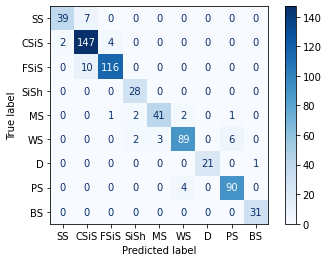

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cv_conf,
                             display_labels=facies_labels)
disp.plot(cmap='Blues') 

We can also consider the classification metrics when we consider misclassifying an adjacent facies as correct:

In [40]:
def confusion_matrix_adjacent(conf,adjacent_facies):
    cv_conf_adj = conf.copy()

    # Consider adjancents as corret
    nb_classes = conf.shape[0]

    for i in np.arange(0,nb_classes):
        for j in adjacent_facies[i]:
            cv_conf_adj[i,i] += conf[i,j]
            cv_conf_adj[i,j] = 0 
    return cv_conf_adj

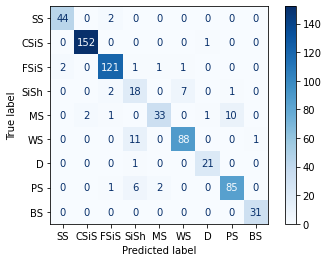

In [41]:
cv_conf_adj = confusion_matrix_adjacent(conf,adjacent_facies )

disp = ConfusionMatrixDisplay(confusion_matrix=cv_conf_adj,
                             display_labels=facies_labels)
disp.plot(cmap='Blues') 

### Testing - Applying the classification model to a new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data.  It is loaded into a dataframe called `facies_test_data.csv`.

In [42]:
well_data = pd.read_csv('facies_test_data.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,3
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3


In [43]:
well_features = well_data.drop(['Formation', 'Well Name', 'Depth', 'Facies'], axis=1)
well_features

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,66.276,0.630,3.300,10.650,3.591,1,1.000
1,77.252,0.585,6.500,11.950,3.341,1,0.978
2,82.899,0.566,9.400,13.600,3.064,1,0.956
3,80.671,0.593,9.500,13.250,2.977,1,0.933
4,75.971,0.638,8.700,12.350,3.020,1,0.911
...,...,...,...,...,...,...,...
825,86.078,0.554,5.040,16.150,3.161,1,0.639
826,88.855,0.539,5.560,16.750,3.118,1,0.611
827,90.490,0.530,6.360,16.780,3.168,1,0.583
828,90.975,0.522,7.035,16.995,3.154,1,0.556


In [44]:
y_test = well_data['Facies'].values

The data needs to be scaled using the same constants we used for the training data.

In [45]:
X_test = scaler.transform(well_features)

Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [46]:
#predict facies of unclassified data
y_pred = clf.predict(X_test)
well_data['Prediction'] = y_pred
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies,Prediction
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3,3
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3,3
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3,3


Let's see how we did with the confusion matrix:

In [47]:
cv_conf = confusion_matrix(y_test, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.87
Optimized adjacent facies classification accuracy = 0.96


Pretty good in my opinion!

## So, let's take a look on the the facies plot

In [48]:
well_data['Well Name'].unique()

['STUART', 'CRAWFORD']
Categories (2, object): ['STUART', 'CRAWFORD']

We can use the well log plot to view the classification results along with the well logs.

In [49]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def compare_facies_plot(logs, prediction, facies_colors):
    n_facies  = len(facies_colors)
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')

    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    cluster2 = np.repeat(np.expand_dims(logs[prediction].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0.5,vmax=n_facies+.5)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                     cmap=cmap_facies,vmin=0.5,vmax=n_facies+.5)
    cbar = plt.colorbar(im2,ticks=np.arange(1,n_facies+1))
    cbar.set_ticklabels(facies_labels)
  
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(prediction)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);
    ax[5].set_xticklabels([]); ax[5].set_xticklabels([])
    ax[6].set_yticklabels([]); ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

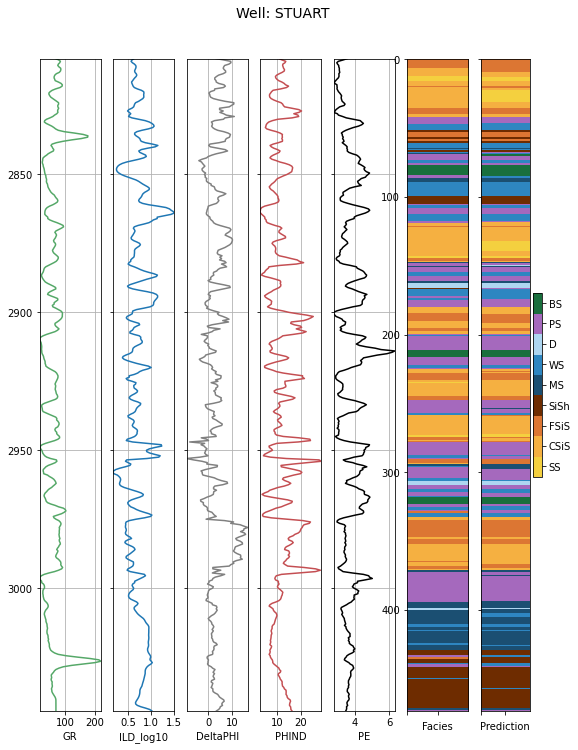

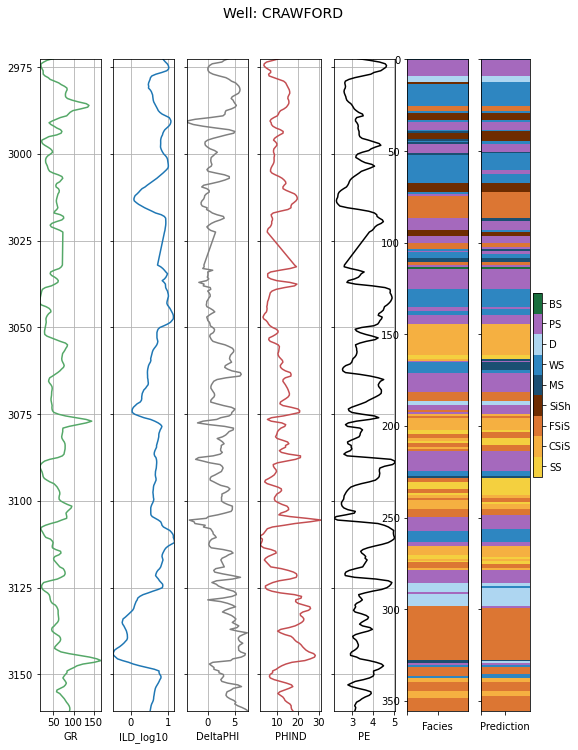

In [50]:
compare_facies_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    'Prediction',
    facies_colors=facies_colors)

compare_facies_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    'Prediction',
    facies_colors=facies_colors)

## Trying Other Methods

The good (but also the bad) thing of python and scikit learn is that we can easily  test different methods

### Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression 
##### Insert your code here #############

lregression = LogisticRegression()



#########################################



**Hyperparameter optimization / Cross-validation**

In [52]:
# dictionary with keys
##### Insert your code here #############
param_grid_strat={'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
                 'C' : [0.1, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000]}
#########################################

# what parameters to search depends on the expert knowledge
##### Insert your code here #############
grid = GridSearchCV(lregression, param_grid =param_grid_strat, cv=cv_strategy)
grid.fit(X_train, y_train)
#########################################
print(grid.best_params_) 

{'C': 0.1, 'penalty': 'l2'}


**Training**

In [53]:
##### Insert your code here #############
clf = LogisticRegression(**grid.best_params_)
clf.fit(X_train, y_train)
#########################################

LogisticRegression(C=0.1)

**Test**

In [54]:
##### Insert your code here #############
y_pred = clf.predict(X_test)
cv_conf = confusion_matrix(y_test,y_pred)

################################

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.56
Optimized adjacent facies classification accuracy = 0.84


### K-Nearest Neighbor

In [55]:
from sklearn.neighbors import KNeighborsClassifier
##### Insert your code here #############
knnclf = KNeighborsClassifier()
#########################################

**Hyperparameter optimization / Cross-validation**

In [56]:
# dictionary with keys
##### Insert your code here #############
param_grid_strat = {'n_neighbors': [5, 10, 50, 70],
                    'algorithm': ['ball_tree','kd_tree','brute']}
                    
#########################################

# what parameters to search depends on the expert knowledge
##### Insert your code here #############
grid = GridSearchCV(knnclf, param_grid =param_grid_strat, cv=cv_strategy)
grid.fit(X_train, y_train)
#########################################
print(grid.best_params_) 

{'algorithm': 'brute', 'n_neighbors': 5}


**Training**

In [57]:
##### Insert your code here #############
clf = KNeighborsClassifier(**grid.best_params_)
clf.fit(X_train, y_train)
#########################################

KNeighborsClassifier(algorithm='brute')

**Test**

In [58]:
##### Insert your code here #############
y_pred = clf.predict(X_test)
cv_conf = confusion_matrix(y_test,y_pred)
#########################################

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.65
Optimized adjacent facies classification accuracy = 0.84


### Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

##### Insert your code here #############
rforest = RandomForestClassifier()
#########################################

**Hyperparameter optimization / Cross-validation**

In [60]:
# dictionary with keys
##### Insert your code here #############
param_grid_strat = {'n_estimators' : [10, 100, 200, 500],
                   'min_samples_split': [2, 7, 15]}
#########################################

# what parameters to search depends on the expert knowledge
##### Insert your code here #############
grid = GridSearchCV(rforest, param_grid =param_grid_strat, cv=cv_strategy )
grid.fit(X_train, y_train)
#########################################
print(grid.best_params_) 

{'min_samples_split': 2, 'n_estimators': 500}


**Training**

In [61]:
##### Insert your code here #############
clf = RandomForestClassifier(**grid.best_params_)
clf.fit(X_train, y_train)
#########################################

RandomForestClassifier(n_estimators=500)

**Test**

In [62]:
##### Insert your code here #############
y_pred = clf.predict(X_test)
cv_conf = confusion_matrix(y_test,y_pred)
#########################################

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.66
Optimized adjacent facies classification accuracy = 0.85


## References

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, *KGS Open-File Report* 2003-50, 6 pp. [pdf](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617 pp. [doi:10.1016/j.cageo.2006.08.011](http://dx.doi.org/10.1016/j.cageo.2006.08.011)